In [39]:
import torch
from torch import nn, optim
import torch.utils.data as torch_data
import torch.nn.functional as F
import itertools as it
import numpy as np
import random
from itertools import combinations, product
from mutex import EncDec, Vocab, batch_seqs, Mutex
from data import encode,  generate_fig2_exp, Oracle, collate, eval_format
from absl import app, flags
import sys
import os

In [40]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 250

In [3]:
input_symbols_list   = set(['dax', 'lug', 'wif', 'zup', 'fep', 'blicket', 'kiki', 'tufa', 'gazzer'])
output_symbols_list  = set(['RED', 'YELLOW', 'GREEN', 'BLUE', 'PURPLE', 'PINK'])

In [4]:
study, test = generate_fig2_exp(input_symbols_list, output_symbols_list)

color map:  {'wif': 'PURPLE', 'blicket': 'RED', 'kiki': 'YELLOW', 'lug': 'BLUE'}
function names:  ['dax', 'fep', 'zup']


In [5]:
study

[(['wif'], ['PURPLE']),
 (['blicket'], ['RED']),
 (['kiki'], ['YELLOW']),
 (['lug'], ['BLUE']),
 (['blicket', 'dax'], ['RED', 'RED', 'RED']),
 (['kiki', 'dax'], ['YELLOW', 'YELLOW', 'YELLOW']),
 (['kiki', 'fep', 'lug'], ['YELLOW', 'BLUE', 'YELLOW']),
 (['wif', 'fep', 'blicket'], ['PURPLE', 'RED', 'PURPLE']),
 (['wif', 'zup', 'lug'], ['BLUE', 'PURPLE']),
 (['blicket', 'zup', 'lug'], ['BLUE', 'RED']),
 (['lug', 'fep', 'wif', 'dax'],
  ['BLUE', 'PURPLE', 'PURPLE', 'PURPLE', 'BLUE']),
 (['lug', 'fep', 'blicket', 'dax'], ['BLUE', 'RED', 'RED', 'RED', 'BLUE']),
 (['wif', 'fep', 'wif', 'zup', 'lug'], ['PURPLE', 'BLUE', 'PURPLE', 'PURPLE']),
 (['wif', 'zup', 'wif', 'fep', 'lug'],
  ['PURPLE', 'PURPLE', 'BLUE', 'PURPLE', 'PURPLE'])]

In [6]:
test

[(['wif', 'dax'], ['PURPLE', 'PURPLE', 'PURPLE']),
 (['lug', 'dax'], ['BLUE', 'BLUE', 'BLUE']),
 (['wif', 'fep', 'lug'], ['PURPLE', 'BLUE', 'PURPLE']),
 (['wif', 'fep', 'kiki'], ['PURPLE', 'YELLOW', 'PURPLE']),
 (['kiki', 'zup', 'lug'], ['BLUE', 'YELLOW']),
 (['wif', 'zup', 'kiki'], ['YELLOW', 'PURPLE']),
 (['blicket', 'zup', 'kiki', 'dax'], ['YELLOW', 'YELLOW', 'YELLOW', 'RED']),
 (['lug', 'fep', 'blicket', 'dax'], ['BLUE', 'RED', 'RED', 'RED', 'BLUE']),
 (['wif', 'zup', 'blicket', 'fep', 'blicket'],
  ['RED', 'PURPLE', 'RED', 'RED', 'PURPLE']),
 (['kiki', 'dax', 'fep', 'kiki', 'zup', 'kiki'],
  ['YELLOW',
   'YELLOW',
   'YELLOW',
   'YELLOW',
   'YELLOW',
   'YELLOW',
   'YELLOW',
   'YELLOW']),
 (['blicket', 'dax', 'fep', 'blicket', 'zup', 'wif'],
  ['RED', 'RED', 'RED', 'PURPLE', 'RED', 'RED', 'RED', 'RED'])]

In [12]:
FLAGS = flags.FLAGS
flags_dict = FLAGS._flags()
keys_list = [keys for keys in flags_dict]
for keys in keys_list: delattr(FLAGS,keys)
flags.DEFINE_integer("dim", 200, "trasnformer dimension")
flags.DEFINE_integer("n_layers", 1, "number of rnn layers")
flags.DEFINE_integer("n_batch", 1, "batch size")
flags.DEFINE_integer("n_epochs",4, "number of training epochs")
flags.DEFINE_float("lr", 0.001, "learning rate")
flags.DEFINE_float("dropout", 0.05, "dropout")
flags.DEFINE_string("save_model", "model.m", "model save location")
flags.DEFINE_integer("seed", 10, "random seed")
flags.DEFINE_bool("debug", False, "debug mode")
FLAGS(['mutex.ipynb'])

['mutex.ipynb']

In [13]:
DEVICE = torch.device("cuda:0")

In [14]:
def pretrain(model, train_dataset, val_dataset):
    opt = optim.Adam(model.parameters(), lr=FLAGS.lr)
    train_loader = torch_data.DataLoader(
        train_dataset, batch_size=FLAGS.n_batch, shuffle=False, 
        collate_fn=collate
    )
    best_loss  = np.inf
    for i_epoch in range(FLAGS.n_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        for inp, _ in train_loader:
            x = inp[:-1,:]
            pred, *extras = model(None, x.shape[0], x.to(DEVICE))
            output = pred.view(-1, len(model.vocab))
            loss = model.nllreduce(output,inp[1:, :].view(-1).to(DEVICE))
            opt.zero_grad()
            loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            train_loss    += loss.item() * inp.shape[1]
            train_batches += inp.shape[1]

        if (i_epoch + 1) % 3 != 0:
            continue

        curr_loss = train_loss / train_batches
        best_loss = min(best_loss, curr_loss)
        print(curr_loss)
        torch.save(model.state_dict(), FLAGS.save_model)

    print("best_loss", best_loss)

    
    
def train(model, train_dataset, val_dataset):
    opt = optim.Adam(model.parameters(), lr=FLAGS.lr)
    train_loader = torch_data.DataLoader(
        train_dataset, batch_size=FLAGS.n_batch, shuffle=False, 
        collate_fn=collate
    )
    best_f1  = -np.inf
    best_acc = -np.inf
    for i_epoch in range(FLAGS.n_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        for inp, out in train_loader:
            nll = model(inp.to(DEVICE), out.to(DEVICE))
            loss = nll.mean()
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            train_loss += loss.item()
            train_batches += 1
        
        if (i_epoch + 1) % 3 != 0:
            continue
            
        
        print(train_loss / train_batches)
        acc, f1 = validate(model, val_dataset)
        print(f"epoch_{i_epoch}_acc", acc)
        print(f"epoch_{i_epoch}_f1", f1)
        best_f1 = max(best_f1, f1)
        best_acc = max(best_acc, acc)
        print()
        torch.save(model.state_dict(), FLAGS.save_model)

    print("final_acc", acc)
    print("final_f1", f1)
    print("best_acc", best_acc)
    print("best_f1", best_f1)


def validate(model, val_dataset, vis=False, tag=[]):
    model.eval()
    print("qxy samples: ", model.sample_qxy(model.py.sample(5,5),temp=1.0))
    first = True
    val_loader = torch_data.DataLoader(
        val_dataset, batch_size=FLAGS.n_batch, shuffle=True, 
        collate_fn=collate
    )
    total = 0
    correct = 0
    tp = 0
    fp = 0
    fn = 0
    with torch.no_grad():
        for inp, out in val_loader:
            pred, _ = model.sample(inp.to(DEVICE), temp=model.temp, max_len=model.max_len, greedy=True)
            for i, seq in enumerate(pred):
                ref = out[:, i].detach().cpu().numpy().tolist()
                ref = eval_format(model.vocab, ref)
                pred_here = eval_format(model.vocab, pred[i])
                correct_here = pred_here == ref
                correct += correct_here
                tp_here = len([p for p in pred_here if p in ref])
                tp += tp_here
                fp_here = len([p for p in pred_here if p not in ref])
                fp += fp_here
                fn_here = len([p for p in ref if p not in pred_here])
                fn += fn_here
                path = "/" + "/".join(tag)
                if vis:
                    print(f"@{path}/{total}", correct_here, tp_here, fp_here, fn_here)
                    inp_lst = inp[:, i].detach().cpu().numpy().tolist()
                    print(eval_format(model.vocab, inp_lst))
                    print("gold", ref)
                    print("pred", pred_here)
                    print(pred_here == ref)
                    print()
                total += 1

    acc = correct / total
    if tp+fp > 0:
        prec = tp / (tp + fp)
    else:
        prec=0
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return acc, f1

def swap_io(items):
    return [(y,x) for (x,y) in items]

In [15]:
def main(model=None):
    np.random.seed(FLAGS.seed)
    torch.manual_seed(FLAGS.seed)
    vocab = Vocab()
    for sym in input_symbols_list.union(output_symbols_list): 
        vocab.add(sym)
        
    study, test = generate_fig2_exp(input_symbols_list, output_symbols_list)
#     for (x,y) in study[0:4]:
#         for sym in x+y:
# #             vocab.add(sym)
#     test  = study[3:4]
#     study  = study[0:3]
  
    
    train_items, test_items = encode(study,vocab), encode(test,vocab)
    


    outlist = list(output_symbols_list)

    oracle_py  = Oracle(vocab, train_items, test_items, DEVICE, dist="py")
    oracle_px  = Oracle(vocab, train_items, test_items, DEVICE, dist="px")
    oracle_qxy = Oracle(vocab, train_items, test_items, DEVICE, dist="qxy")
    
    if model is None:
        model = Mutex(vocab, 
                      FLAGS.dim, 
                      FLAGS.dim, 
                      oracle_py, 
                      max_len=7,
                      copy=False, 
                      n_layers=FLAGS.n_layers, 
                      self_att=False, 
                      dropout=FLAGS.dropout,
                      lamda=0.1,
                      Nsample=200,
                     ).to(DEVICE)
    
    if not isinstance(model.px,Oracle):
        pretrain(model.px, train_items + test_items, test_items)
        
    print("px samples: ")
    print(model.sample_px(50))
    print("py samples: ")
    print(model.sample_py(50))
    
#     if not isinstance(model.qxy,Oracle):
#         train(model.qxy, swap_io(train_items) + swap_io(test_items), swap_io(test_items))
#     if not isinstance(model.pyx,Oracle):
#         train(model.pyx, train_items + test_items, test_items)
#         for param in model.pyx.parameters():
#             param.requires_grad = False
    
    print("qxy samples: ", model.sample_qxy(model.py.sample(5,5),temp=1.0))
    
    train(model, train_items, test_items)
    return model, study, test

In [16]:
model, study, test = main()

color map:  {'kiki': 'PURPLE', 'blicket': 'PINK', 'tufa': 'YELLOW', 'gazzer': 'BLUE'}
function names:  ['fep', 'dax', 'zup']
1.2563204956054688
best_loss 1.2563204956054688
px samples: 
['<s> kiki zup kiki dax gazzer </s>', '<s> tufa </s>', '<s> kiki dax kiki dax blicket zup </s>', '<s> kiki fep kiki zup tufa </s>', '<s> kiki zup blicket dax gazzer </s>', '<s> tufa dax blicket zup blicket zup </s>', '<s> tufa dax gazzer fep </s>', '<s> kiki zup gazzer </s>', '<s> tufa dax kiki zup kiki dax </s>', '<s> tufa fep </s>', '<s> kiki dax blicket zup blicket fep </s>', '<s> gazzer dax blicket </s>', '<s> </s>', '<s> kiki zup blicket fep </s>', '<s> kiki zup kiki fep </s>', '<s> kiki </s>', '<s> kiki zup kiki zup tufa gazzer </s>', '<s> blicket </s>', '<s> gazzer </s>', '<s> kiki zup blicket zup gazzer </s>', '<s> kiki dax tufa </s>', '<s> tufa </s>', '<s> blicket fep </s>', '<s> kiki zup blicket zup gazzer </s>', '<s> blicket zup blicket fep </s>', '<s> blicket fep zup kiki zup gazzer </s>', '

In [12]:
FLAGS.debug = False

In [37]:
def sample_qxy_debug(model,N=10):
    with torch.no_grad():
        ys = model.py.sample(N,model.max_len,temp=model.temp)
        xs, _ = model.qxy.sample(ys, model.max_len, temp=model.temp)
        xs   = batch_seqs(xs).to(ys.device)
        logprob_qxy = model.qxy.logprob(ys, xs).cpu().numpy().tolist()
        xs  = xs.cpu().numpy().transpose().tolist()
        ys  = ys.cpu().numpy().transpose().tolist()
        sxs = model.print_tokens(xs)
        sys = model.print_tokens(ys)
        for (x,y,prob) in zip(sxs,sys,logprob_qxy):
            print("x: ",x,"\t","y: ",y,"\t","logp: ",prob)

         
    

In [38]:
sample_qxy_debug(model,N=10)

x:  <s> blicket blicket blicket zup blicket <copy> </s> 	 y:  <s> BLUE BLUE BLUE </s> <pad> <pad> <pad> <pad> <pad> 	 logp:  -10.422517776489258
x:  <s> tufa <s> tufa tufa zup RED </s> 	 y:  <s> YELLOW </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 	 logp:  -15.579282760620117
x:  <s> blicket blicket dax gazzer zup blicket </s> 	 y:  <s> PINK PINK PINK PINK </s> <pad> <pad> <pad> <pad> 	 logp:  -7.9517059326171875
x:  <s> kiki <s> gazzer lug dax tufa </s> 	 y:  <s> PURPLE </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 	 logp:  -14.631431579589844
x:  <s> kiki fep kiki lug fep dax </s> 	 y:  <s> PURPLE BLUE PURPLE </s> <pad> <pad> <pad> <pad> <pad> 	 logp:  -10.543964385986328
x:  <s> blicket dax gazzer zup gazzer dax </s> 	 y:  <s> BLUE PINK PINK BLUE </s> <pad> <pad> <pad> <pad> 	 logp:  -9.307907104492188
x:  <s> tufa fep kiki dax tufa zup </s> 	 y:  <s> YELLOW YELLOW YELLOW PURPLE YELLOW YELLOW YELLOW YELLOW </s> 	 logp:  -8.43450927734375
x:  <s> kiki zup blicket lug dax kiki </s> 

In [13]:
print(model.sample_px(1))

['<s> tufa wif zup </s>']


In [14]:
ys = model.py.sample(1,7)

In [15]:
cxs, _ = model.qxy.sample_with_gumbel(ys, model.max_len, temp=model.temp) 

In [16]:
print("qxy samples: ", model.sample_qxy(model.py.sample(1,7),temp=1.0))

qxy samples:  ['<s> lug tufa lug tufa fep </s>']


In [17]:
print("qxy samples: ", model.sample_qxy_gumbel(model.py.sample(1,7),temp=1.0))

qxy samples:  ['<s> lug zup lug zup lug zup </s>']


In [18]:
xs, _ = model.qxy.sample(ys, model.max_len, temp=model.temp)
ux = [list(x) for x in set(tuple(x) for x in xs)]
xps   = batch_seqs(ux).to(DEVICE)

In [19]:
xps

tensor([[ 1],
        [ 7],
        [10],
        [10],
        [ 7],
        [10],
        [10],
        [ 2]], device='cuda:0')

In [20]:
logprob_px = model.px.logprob(xps)

In [21]:
logprob_px

tensor([-32.9518], device='cuda:0', grad_fn=<NegBackward>)

In [22]:
torch.exp(logprob_px)

tensor([4.8891e-15], device='cuda:0', grad_fn=<ExpBackward>)

In [23]:
for y in ys.split(1,dim=1):
    ybatch = y.repeat(1, xps.shape[1])
    logprob_qxy = model.qxy.logprob(ybatch, xps)
    print(logprob_qxy)

tensor([-0.4129], device='cuda:0', grad_fn=<NegBackward>)


In [24]:
torch.exp(logprob_qxy)

tensor([0.6617], device='cuda:0', grad_fn=<ExpBackward>)

In [25]:
print("qxy samples: ", model.sample_qxy(ys,temp=1.0))

qxy samples:  ['<s> lug dax dax lug dax dax </s>']


In [26]:
ys

tensor([[1],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [2]], device='cuda:0')

In [27]:
validate(model, encode(test,model.vocab), vis=True)

qxy samples:  ['<s> lug dax dax zup lug tufa </s>', '<s> tufa lug tufa fep tufa tufa </s>', '<s> tufa wif zup dax dax </s>', '<s> lug zup lug zup lug zup </s>', '<s> lug wif lug dax lug dax </s>']
@//0 False 2 0 2
['tufa', 'lug', 'dax', 'wif', 'zup']
gold ['GREEN', 'BLUE', 'PURPLE', 'GREEN']
pred ['BLUE', 'PURPLE']
False

@//1 False 3 0 0
['zup', 'wif', 'zup', 'fep']
gold ['BLUE', 'BLUE', 'BLUE', 'BLUE']
pred ['BLUE', 'BLUE', 'BLUE']
False

@//2 False 0 1 2
['kiki', 'wif', 'tufa']
gold ['GREEN', 'YELLOW']
pred ['BLUE']
False

@//3 False 3 0 0
['tufa', 'wif', 'tufa', 'fep']
gold ['GREEN', 'GREEN', 'GREEN', 'GREEN']
pred ['GREEN', 'GREEN', 'GREEN']
False

@//4 True 3 0 0
['kiki', 'lug', 'tufa']
gold ['YELLOW', 'GREEN', 'YELLOW']
pred ['YELLOW', 'GREEN', 'YELLOW']
True

@//5 False 2 0 0
['tufa', 'lug', 'zup']
gold ['GREEN', 'BLUE', 'GREEN']
pred ['BLUE', 'GREEN']
False

@//6 False 1 1 1
['tufa', 'wif', 'dax']
gold ['PURPLE', 'GREEN']
pred ['BLUE', 'GREEN']
False

@//7 False 4 2 0
['dax', 

(0.09090909090909091, 0.7536231884057972)

In [28]:
validate(model, encode(study,model.vocab), vis=True)

qxy samples:  ['<s> lug dax dax lug dax dax </s>', '<s> lug wif lug tufa fep </s>', '<s> tufa tufa tufa tufa lug tufa </s>', '<s> tufa kiki lug kiki tufa kiki </s>', '<s> lug zup lug zup lug zup </s>']
@//0 True 3 0 0
['kiki', 'lug', 'dax']
gold ['YELLOW', 'PURPLE', 'YELLOW']
pred ['YELLOW', 'PURPLE', 'YELLOW']
True

@//1 True 3 0 0
['zup', 'fep']
gold ['BLUE', 'BLUE', 'BLUE']
pred ['BLUE', 'BLUE', 'BLUE']
True

@//2 True 1 0 0
['kiki']
gold ['YELLOW']
pred ['YELLOW']
True

@//3 True 1 0 0
['zup']
gold ['BLUE']
pred ['BLUE']
True

@//4 True 2 0 0
['tufa', 'wif', 'zup']
gold ['BLUE', 'GREEN']
pred ['BLUE', 'GREEN']
True

@//5 True 2 0 0
['dax', 'wif', 'zup']
gold ['BLUE', 'PURPLE']
pred ['BLUE', 'PURPLE']
True

@//6 True 3 0 0
['tufa', 'fep']
gold ['GREEN', 'GREEN', 'GREEN']
pred ['GREEN', 'GREEN', 'GREEN']
True

@//7 True 4 0 0
['zup', 'lug', 'dax', 'wif', 'tufa']
gold ['BLUE', 'GREEN', 'PURPLE', 'BLUE']
pred ['BLUE', 'GREEN', 'PURPLE', 'BLUE']
True

@//8 False 3 0 1
['tufa', 'wif', 'k

(0.9285714285714286, 0.9863013698630138)

In [29]:
model.loss_container

[LossTrack(nll=2.9946553707122803, mlogpyx=1988.8585205078125, pointkl=-0.040283747017383575),
 LossTrack(nll=2.9591336250305176, mlogpyx=2531.512939453125, pointkl=-0.05201037600636482),
 LossTrack(nll=2.824923038482666, mlogpyx=2000.39599609375, pointkl=-0.05419357120990753),
 LossTrack(nll=2.75211763381958, mlogpyx=2634.205810546875, pointkl=-0.0800485908985138),
 LossTrack(nll=2.6608688831329346, mlogpyx=1665.288330078125, pointkl=-0.09817420691251755),
 LossTrack(nll=2.6447696685791016, mlogpyx=1722.3896484375, pointkl=-0.10523458570241928),
 LossTrack(nll=2.2777504920959473, mlogpyx=2288.78466796875, pointkl=-0.09124542027711868),
 LossTrack(nll=2.39228892326355, mlogpyx=2449.8359375, pointkl=-0.10313226282596588),
 LossTrack(nll=2.048809289932251, mlogpyx=1856.2838134765625, pointkl=-0.12550397217273712),
 LossTrack(nll=1.833437442779541, mlogpyx=2327.611572265625, pointkl=-0.0737752690911293),
 LossTrack(nll=1.989569902420044, mlogpyx=1564.41748046875, pointkl=-0.12332972884178

In [30]:
df = pd.DataFrame(model.loss_container)

In [31]:
df

,nll,mlogpyx,pointkl
0,2.994655,1988.858521,-0.040284
1,2.959134,2531.512939,-0.052010
2,2.824923,2000.395996,-0.054194
3,2.752118,2634.205811,-0.080049
4,2.660869,1665.288330,-0.098174
...,...,...,...
695,0.000308,1815.210327,-0.201684
696,0.001033,1662.670044,-0.200853
697,0.005214,2510.813477,-0.198716
698,0.000240,2444.392334,-0.186086


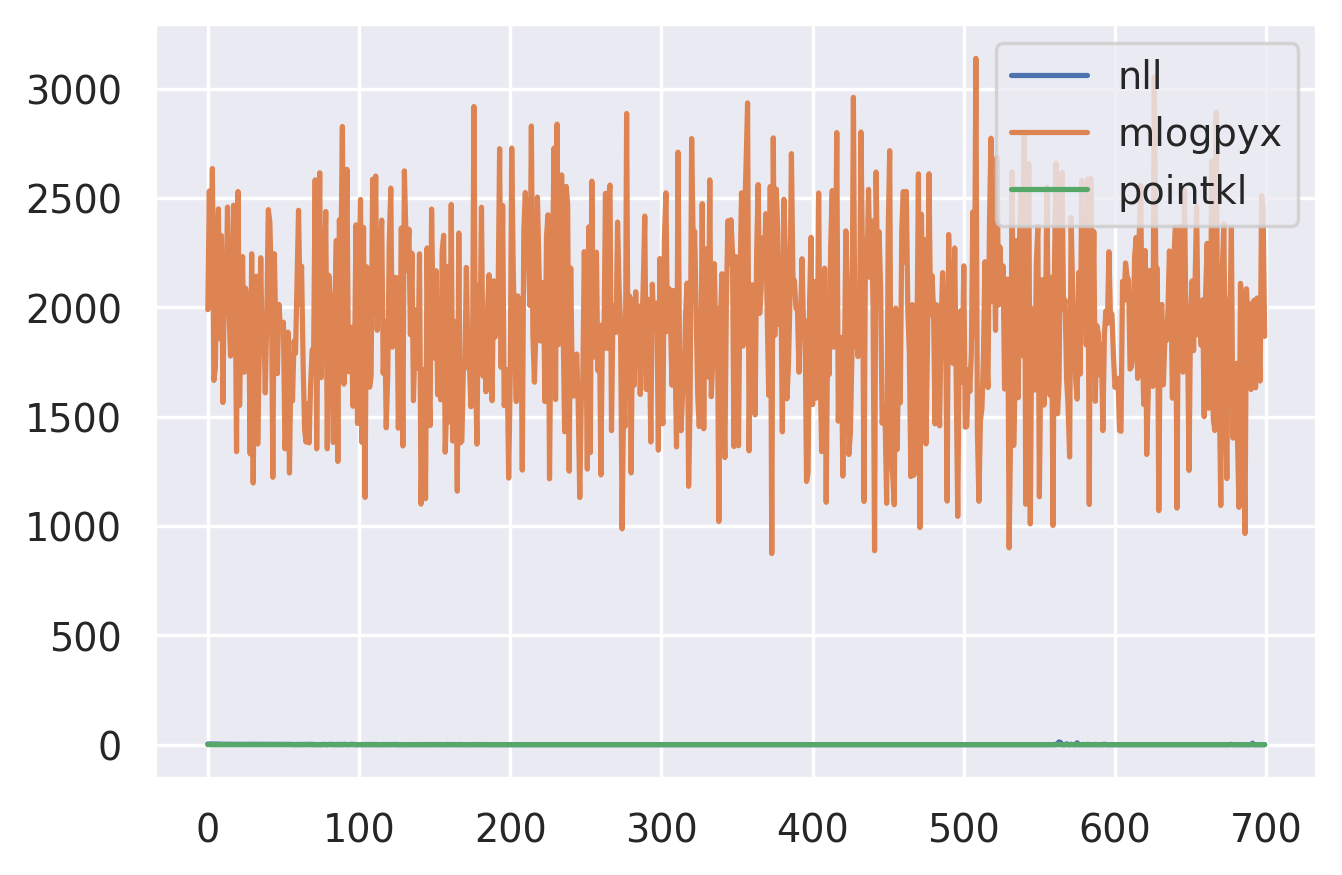

In [32]:
ax = sns.lineplot(data=df, dashes=False)